In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# 한글폰트 사용 in colab
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

# **데이터 로드 및 탐색**

In [4]:
# df = pd.read_csv("/content/drive/MyDrive/1-0. 서강대/1. 빅데이터 예측 분석 팀플 (6팀)/기말 팀 프로젝트/코드/dataset.csv")
df = pd.read_csv("/content/drive/MyDrive/1-0. 서강대/1. 빅데이터 예측 분석 팀플 (6팀)/기말 팀 프로젝트/코드/dataset2.csv")

In [5]:
df = df.drop(['Unnamed: 0'], axis=1)
dfX = df.drop(['연체 여부'], axis=1)
dfy = pd.DataFrame(df, columns=["연체 여부"]) # 종속 변수로 DLQ 설정
print(dfX.shape, dfy.shape)

(26805, 5) (26805, 1)


# **train, test 분리 (8:2)**

In [6]:
from sklearn.model_selection import train_test_split

# train, test 데이터 분리
X_train , X_test , y_train , y_test = train_test_split(dfX , dfy , test_size=0.2, shuffle=True)  # random_state=156
print(X_train.shape, X_test.shape)

(21444, 5) (5361, 5)


# **모델 학습 - Decision Tree**

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)

# GridSearch
parameters = {'max_depth':list(range(1,11)), 
              'min_samples_split':list(range(1,6)), 
              'min_samples_leaf':list(range(1,6))}

grid_dt = GridSearchCV(dt, param_grid=parameters, cv=3, refit=True, scoring='f1')

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [1, 2, 3, 4, 5]},
             scoring='f1')

In [12]:
scores_df = pd.DataFrame(grid_dt.cv_results_)
scores_df = scores_df[(scores_df['rank_test_score'] < 6)]
scores_df[['params', 'mean_test_score', 'rank_test_score']]
# scores_df[['split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score
91,"{'max_depth': 4, 'min_samples_leaf': 4, 'min_s...",0.893138,1
92,"{'max_depth': 4, 'min_samples_leaf': 4, 'min_s...",0.893138,1
93,"{'max_depth': 4, 'min_samples_leaf': 4, 'min_s...",0.893138,1
94,"{'max_depth': 4, 'min_samples_leaf': 4, 'min_s...",0.893138,1
96,"{'max_depth': 4, 'min_samples_leaf': 5, 'min_s...",0.893138,1
97,"{'max_depth': 4, 'min_samples_leaf': 5, 'min_s...",0.893138,1
98,"{'max_depth': 4, 'min_samples_leaf': 5, 'min_s...",0.893138,1
99,"{'max_depth': 4, 'min_samples_leaf': 5, 'min_s...",0.893138,1
121,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.893138,1
122,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.893138,1


In [13]:
print('GridSearchCV 최적 파라미터:', grid_dt.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dt.best_score_))

# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
estimator = grid_dt.best_estimator_

from sklearn.metrics import accuracy_score
# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = estimator.predict(X_test)
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))

GridSearchCV 최적 파라미터: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8931
테스트 데이터 세트 정확도: 0.9968


## **트리 해석 시각화**

In [15]:
dt = DecisionTreeClassifier(random_state=1, max_depth=4, min_samples_leaf=4, min_samples_split=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=4, random_state=1)

In [16]:
from sklearn import tree
dt_text = tree.export_text(dt)
print(dt_text)

|--- feature_0 <= 2.50
|   |--- feature_0 <= 0.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- feature_2 <= 6750.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- feature_2 >  6750.00
|   |   |   |   |--- class: 0.0
|   |   |--- feature_1 >  0.50
|   |   |   |--- feature_4 <= 50.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- feature_4 >  50.00
|   |   |   |   |--- class: 0.0
|   |--- feature_0 >  0.50
|   |   |--- feature_1 <= 2.50
|   |   |   |--- feature_3 <= 0.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- feature_3 >  0.50
|   |   |   |   |--- class: 1.0
|   |   |--- feature_1 >  2.50
|   |   |   |--- feature_4 <= 4200.00
|   |   |   |   |--- class: 0.0
|   |   |   |--- feature_4 >  4200.00
|   |   |   |   |--- class: 0.0
|--- feature_0 >  2.50
|   |--- feature_2 <= 55.00
|   |   |--- feature_4 <= 9550.00
|   |   |   |--- feature_1 <= 23.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- feature_1 >  23.50
|   |   |   |   |--- class: 1.0
|   |   |--- feature_4 >  95

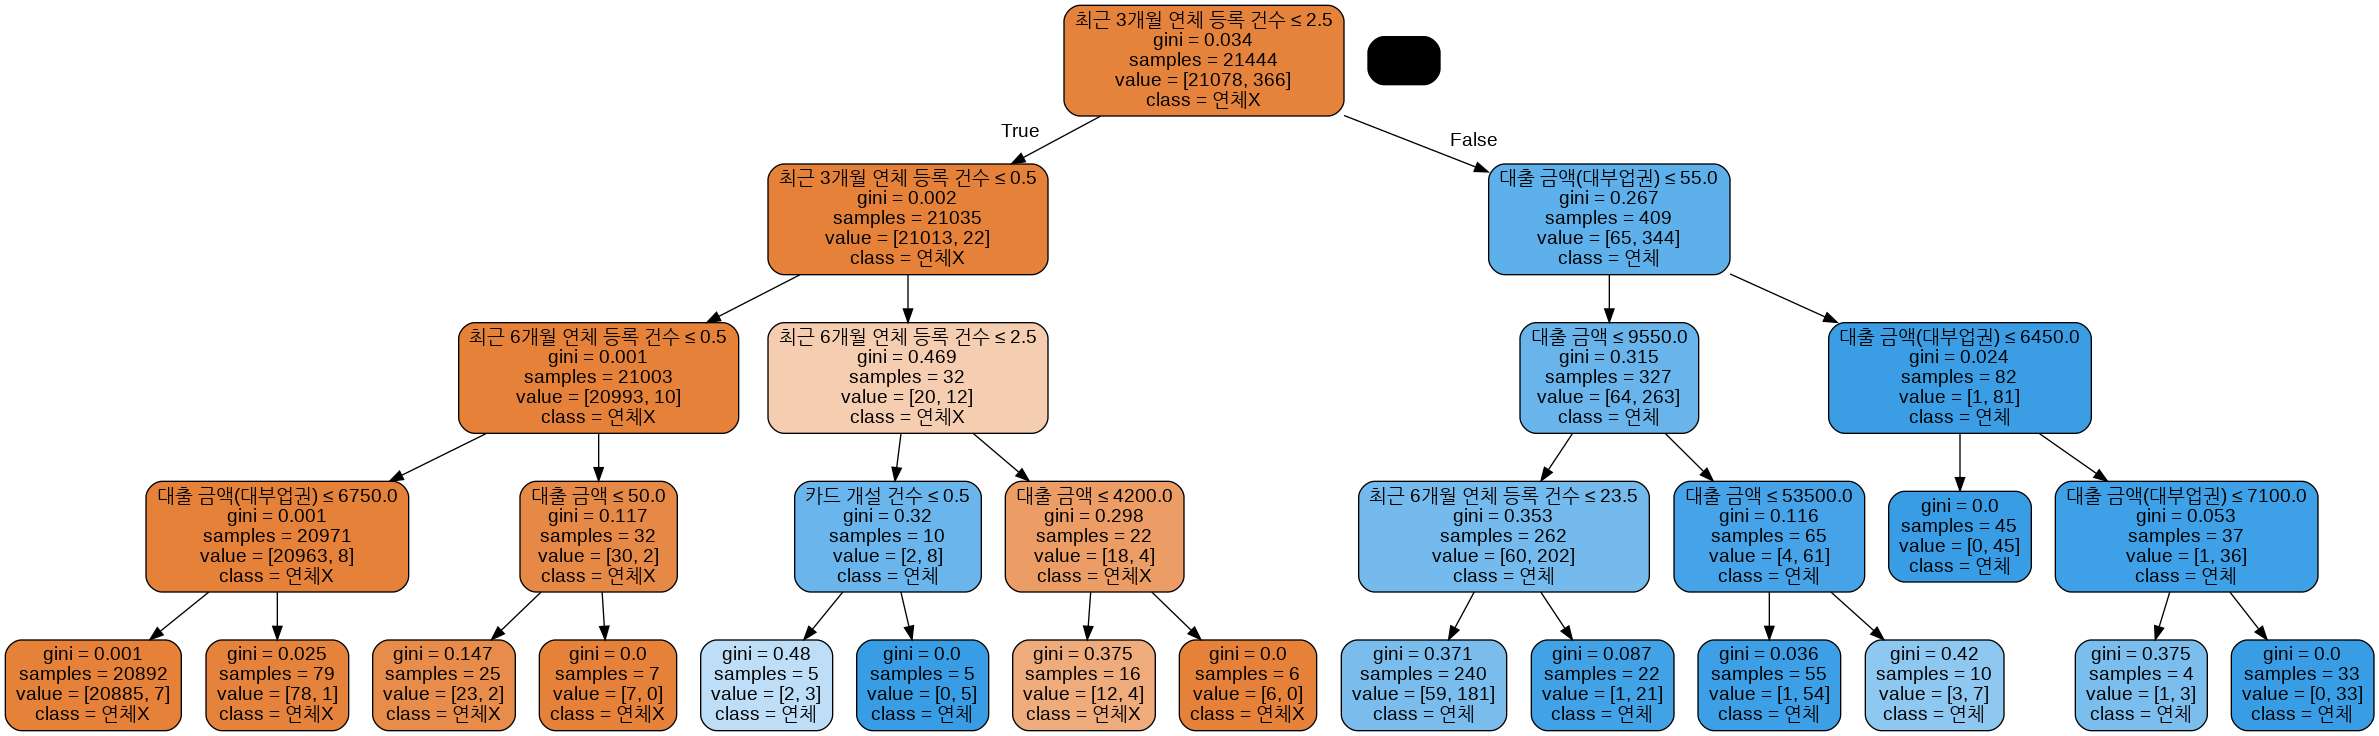

In [17]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import numpy as np

dot_data = export_graphviz(dt, out_file=None, feature_names=dfX.columns.tolist(),
                          class_names=np.array(['연체X', '연체']), filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## **변수 중요도**

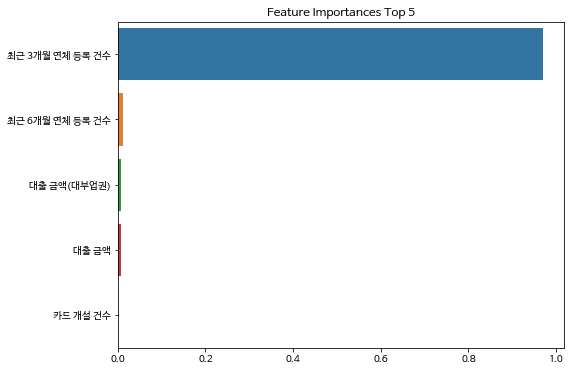

최근 3개월 연체 등록 건수    0.970119
최근 6개월 연체 등록 건수    0.012008
대출 금액(대부업권)        0.008291
대출 금액              0.008232
카드 개설 건수           0.001349
dtype: float64


In [18]:
# Feature Importance
 
import seaborn as sns
feature_importance_values = dt.feature_importances_
# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=dfX.columns)
# 중요도값 순으로 Series를 정렬
feature_top5 = feature_importances.sort_values(ascending=False)[:5] # 10개 혹은 20개 등 개수를 바꾸고 싶다면 이 부분을 변경
 
plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 5')
sns.barplot(x=feature_top5, y=feature_top5.index)
plt.show()

print(feature_top5)

## **예측**

In [19]:
# predict 메소드 : 학습된 모델로 예측을 수행
y_preds_dt = dt.predict(X_test)
print("예측값 : ", y_preds_dt[31:50])
print("실제값 : ", y_test[31:50])

예측값 :  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
실제값 :         연체 여부
4815     0.0
7502     0.0
26212    0.0
2540     1.0
1050     0.0
7448     0.0
23093    0.0
5249     0.0
14042    0.0
9120     0.0
9067     0.0
17626    0.0
16113    0.0
12649    0.0
2657     0.0
5467     0.0
16250    0.0
12019    0.0
9099     0.0


In [20]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import *
import numpy as np

print('accuracy: ', round(accuracy_score(y_test,y_preds_dt.round()), 4))
print('precision: ', precision_score(y_test,y_preds_dt.round()))
print('recall: ', recall_score(y_test,y_preds_dt.round()))
print('f1-score: ', f1_score(y_test,y_preds_dt.round()))
print(classification_report(y_test, y_preds_dt))

accuracy:  0.9968
precision:  0.8571428571428571
recall:  0.9512195121951219
f1-score:  0.9017341040462428
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5279
         1.0       0.86      0.95      0.90        82

    accuracy                           1.00      5361
   macro avg       0.93      0.97      0.95      5361
weighted avg       1.00      1.00      1.00      5361



roc_auc_score for DecisionTree:  0.9743784622919159


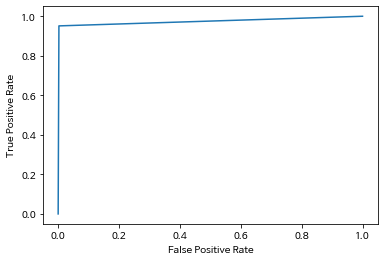

In [21]:
#define metrics
fpr, tpr, _ = roc_curve(y_test, y_preds_dt) # false_positive_rate, true_positive_rate, threshold
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_preds_dt))

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

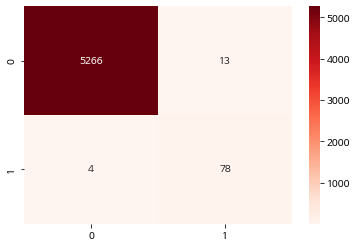

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_preds_dt) 
sns.heatmap(cm, annot=True,  cmap='Reds', fmt='g') # fmt='g': e-notation을 일반표기법으로
plt.show()